## COVID-19 Detection from CT scans

The objective of this project is to develop a model that detects COVID-19 infections from chest CT scans.

## 1. Data collection

In [1]:
!pip3 install opencv-python

In [2]:
#import the necessary libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-26 14:19:06.743385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define paths
data_dir = '/Users/rohanmuru/Projects/COVID-19 Detection using CT scans/archive/'
covid_dir = os.path.join(data_dir, 'COVID')
non_covid_dir = os.path.join(data_dir, 'non-COVID')

In [4]:
#image resize parameters
img_size = (224, 224)

In [5]:
# Load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

In [6]:
# Load COVID images
covid_images, covid_labels = load_images_from_folder(covid_dir, 1)

# Load Non-COVID images
non_covid_images, non_covid_labels = load_images_from_folder(non_covid_dir, 0)

In [7]:
# Combine data
images = np.array(covid_images + non_covid_images)
labels = np.array(covid_labels + non_covid_labels)

In [8]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
print(f'Training set: {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')

Training set: 1984 samples
Validation set: 497 samples


## 2. Model Building

In [11]:
#importing the necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Load the VGG16 model with pre-trained ImageNet weights, excluding the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (COVID-19 or Non-COVID)

In [14]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 3. Model training

In [18]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=len(X_train) // 32,
    verbose=1
)

Epoch 1/20
62/62 [==============================] - 225s 4s/step - loss: 0.5798 - accuracy: 0.6774 - val_loss: 0.4962 - val_accuracy: 0.7404
Epoch 2/20
62/62 [==============================] - 211s 3s/step - loss: 0.5013 - accuracy: 0.7480 - val_loss: 0.4423 - val_accuracy: 0.8109
Epoch 3/20
62/62 [==============================] - 209s 3s/step - loss: 0.4495 - accuracy: 0.7959 - val_loss: 0.4285 - val_accuracy: 0.8028
Epoch 4/20
62/62 [==============================] - 212s 3s/step - loss: 0.4247 - accuracy: 0.8100 - val_loss: 0.4160 - val_accuracy: 0.8249
Epoch 5/20
62/62 [==============================] - 1191s 19s/step - loss: 0.4529 - accuracy: 0.7863 - val_loss: 0.3991 - val_accuracy: 0.8169
Epoch 6/20
62/62 [==============================] - 196s 3s/step - loss: 0.4089 - accuracy: 0.8125 - val_loss: 0.3831 - val_accuracy: 0.8270
Epoch 7/20
62/62 [==============================] - 200s 3s/step - loss: 0.3812 - accuracy: 0.8402 - val_loss: 0.3734 - val_accuracy: 0.8229
Epoch 8/20


## 4. Model Evaluation

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.82


In [20]:
# Save the model
model.save('covid19_ct_detection_model.h5')

In [24]:
# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score

In [25]:
# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

16/16 [==============================] - 39s 2s/step


In [26]:
# Calculate metrics
print(classification_report(y_val, y_pred_classes))
print("ROC-AUC:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       246
           1       0.96      0.69      0.80       251

    accuracy                           0.82       497
   macro avg       0.85      0.83      0.82       497
weighted avg       0.85      0.82      0.82       497

ROC-AUC: 0.9353318433582742


## 5. Plotting the Results

In [21]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy')

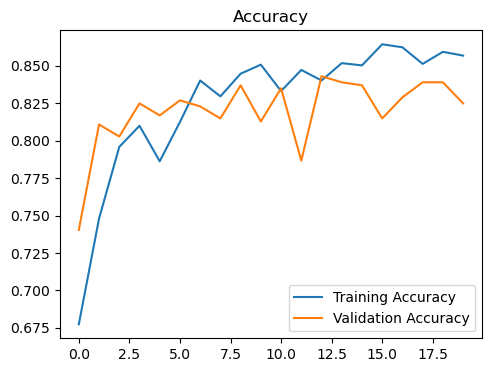

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

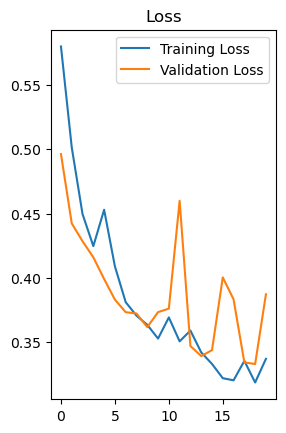

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()